# Anomaly detection for images
## Defect detection for quality control in manufacturing
At manufacturing sites, there are a lot of human experts who perform visual inspections.
Manufacturing companies wants to make this process to be automated somehow.

In this notebook, Convolutional AutoEncoder is applied for Anomaly detection problem.
- Classify the image to two classes; OK or NG.
- Only OK labeled data is given at train phase. (limitation)

## Dataset

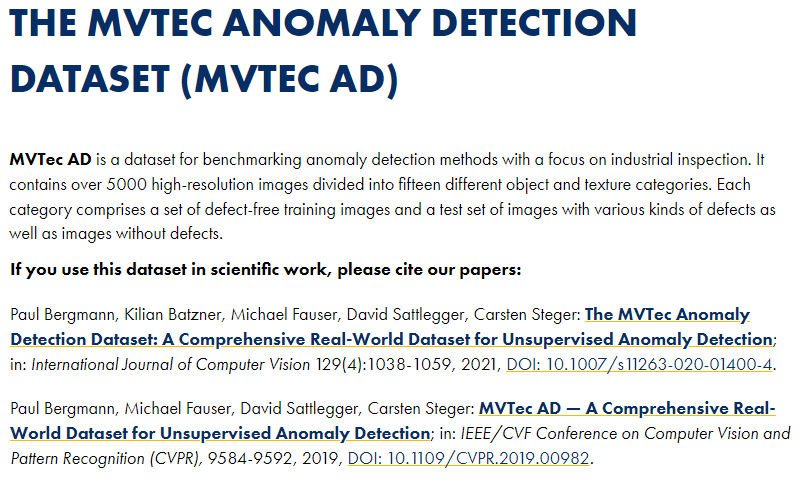

In [1]:
import argparse
import os, sys, glob
import numpy as np
import random as rn
import cv2
import matplotlib.pylab as plt
import json
import time, itertools, logging

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback

### Read images 

In [2]:
def getFilePath(dir):
    pictList = []
    files = glob.glob(os.path.join(dir, '*'))

    for i in range(0, len(files)):
        if os.path.isdir(files[i]):
            pictList.extend(getFilePath(files[i]))
        else:
            if os.path.splitext(files[i])[1] in [".png"]:
                pictList.append(files[i])
    return pictList

In [3]:
def my_imread(filename, flags=cv2.IMREAD_COLOR, dtype=np.uint8):
    try:
        n = np.fromfile(filename, dtype)
        img = cv2.imdecode(n, flags)
        return img
    except Exception as e:
        print(e)
        return None

In [4]:
def prepare_data_ae(list_of_images, img_width, img_height, img_ch):
    """
    Returns two arrays:
        x is an array of resized images
        y is an array of labels
    """

    x = [] # images as arrays

    for image in list_of_images:
        if img_ch == 1:
            im_rgb = my_imread(image, flags=cv2.IMREAD_GRAYSCALE)
            im_rgb = cv2.resize(im_rgb, (img_width,img_height), interpolation=cv2.INTER_LINEAR)
            x.append(np.reshape(im_rgb, (im_rgb.shape[0], im_rgb.shape[1] , 1)))
        else:
            im_rgb = cv2.cvtColor(my_imread(image), cv2.COLOR_BGR2RGB)
            x.append(cv2.resize(im_rgb, (img_width,img_height), interpolation=cv2.INTER_LINEAR))

    return np.array(x), np.array(x)

### Set environment

In [5]:
"keras version {}".format(keras.__version__)

'keras version 2.4.0'

In [6]:
"tensorflow version {}".format(tf.__version__)

'tensorflow version 2.3.0'

In [7]:
gpu_num = 0

In [8]:
if gpu_num is not None:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
    gpu_options=tf.compat.v1.GPUOptions(visible_device_list="{}".format(gpu_num)))

    print("GPU used")
else:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, device_count={'GPU': 0})
    lprint("CPU used")

GPU used


In [9]:
sess = tf.compat.v1.Session(config=session_conf)
set_session(sess)

### Get image parh

In [10]:
TRAIN_DIR = ['capsule\\train']
TEST_DIR = ['capsule\\test']

In [11]:
train_images = []
for idx in TRAIN_DIR:
    train_images = train_images + getFilePath(idx)

test_images = []
for idx in TEST_DIR:
    test_images = test_images + getFilePath(idx)

In [12]:
train_images[:10]

['capsule\\train\\good\\000.png',
 'capsule\\train\\good\\001.png',
 'capsule\\train\\good\\002.png',
 'capsule\\train\\good\\003.png',
 'capsule\\train\\good\\004.png',
 'capsule\\train\\good\\005.png',
 'capsule\\train\\good\\006.png',
 'capsule\\train\\good\\007.png',
 'capsule\\train\\good\\008.png',
 'capsule\\train\\good\\009.png']

In [13]:
print("train_images:{} ".format(len(train_images)))
print("test_images:{} ".format(len(test_images)))

train_images:219 
test_images:109 


### Set image sizes

In [14]:
img_height = 128 
img_width = 128 
img_ch = 3

### Load images

In [15]:
X_train, Y_train = prepare_data_ae(train_images, img_width, img_height, img_ch)
X_val, Y_val = prepare_data_ae(test_images, img_width, img_height, img_ch)

In [16]:
X_train.shape

(219, 128, 128, 3)

In [17]:
Y_train.shape

(219, 128, 128, 3)

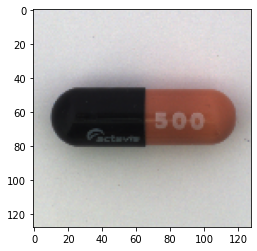

In [18]:
plt.imshow(X_train[0])
plt.show()

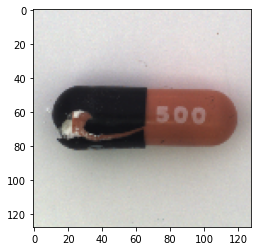

In [19]:
plt.imshow(X_val[1])
plt.show()

### keras cnn

In [20]:
from tensorflow.keras.layers import Activation, LeakyReLU, Conv2D, Dense, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Add, Dropout, BatchNormalization, Convolution2D, concatenate, Reshape, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import optimizers

### Define model

In [21]:
def encode_module(filter_num, inputs, postfix=''):
    x = Conv2D(filter_num, (3, 3), padding='same', name='conv_' + postfix)(inputs)
    x = BatchNormalization(name='bn_' + postfix)(x)
    x = LeakyReLU(name='relu_' + postfix)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool_' + postfix)(x)
    return x

def decode_module(filter_num, inputs, postfix=''):
    x = Conv2DTranspose(filter_num, (3, 3), strides=(2, 2), padding='same', name='deconv_' + postfix)(inputs)
    x = BatchNormalization(name='bn_' + postfix)(x)
    x = LeakyReLU(name='relu_' + postfix)(x)
    return x

In [22]:
def AutoEncoder(input_shape, model_para_list):
    h = input_shape[0]
    w = input_shape[1]
    ch = input_shape[2]
    input_img = Input(shape=input_shape)

    layer_num, layer_ch, latent_dim = model_para_list

    x = encode_module(layer_ch, input_img, 'encode_1')
    for idx in range(layer_num-1):
        layer_ch = int(layer_ch * 2)
        x = encode_module(layer_ch, x, 'encode_{}'.format(idx+2))

    x = Flatten(name='flatten1')(x)
    x = Dense(latent_dim, name='ip1')(x)
    encoder = LeakyReLU(name='relu_ip1')(x)

    dense_h = int(h/(2**layer_num))
    dense_w = int(w/(2**layer_num))
    latent_dim_2 = int(dense_h * dense_w * layer_ch)

    x = Dense(latent_dim_2, name='ip2')(encoder)
    x = LeakyReLU(name='relu_ip2')(x)
    x = Reshape((dense_h, dense_w, layer_ch), name='reshape1')(x)

    x = decode_module(layer_ch, x, 'decode_1')
    for idx in range(layer_num-1):
        layer_ch = int(layer_ch / 2)
        x = decode_module(layer_ch, x, 'decode_{}'.format(idx+2))

    decoder = Conv2D(ch, (1, 1), padding='same', activation='sigmoid', name='conv_channel')(x)

    model = Model(input_img, decoder)
    return model

### Set parameters

In [23]:
# set parameters for Autoencoder
layer_num = 4
layer_ch = 16
latent_dim = 20

model_para = layer_num, layer_ch, latent_dim

In [24]:
model = AutoEncoder((img_height, img_width, img_ch), model_para)

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv_encode_1 (Conv2D)       (None, 128, 128, 16)      448       
_________________________________________________________________
bn_encode_1 (BatchNormalizat (None, 128, 128, 16)      64        
_________________________________________________________________
relu_encode_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
pool_encode_1 (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv_encode_2 (Conv2D)       (None, 64, 64, 32)        4640      
_________________________________________________________________
bn_encode_2 (BatchNormalizat (None, 64, 64, 32)       

### parmeters for train

In [26]:
loss_name = "binary_crossentropy"
optimizer_cls = optimizers.Adam()

In [27]:
model.compile(loss=loss_name, optimizer=optimizer_cls)

In [28]:
train_batch_size = 4
test_batch_size = 4
epochs = 30

### Train

In [29]:
history = model.fit(X_train/255.0, X_train/255.0, 
                    validation_data=(X_val/255.0, X_val/255.0),
                    batch_size=train_batch_size, 
                    epochs=epochs,
                    shuffle=True
                   )

Epoch 1/30
55/55 [==============================] - 1s 24ms/step - loss: 0.5807 - val_loss: 0.6194
Epoch 2/30
55/55 [==============================] - 1s 12ms/step - loss: 0.5118 - val_loss: 0.5788
Epoch 3/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4943 - val_loss: 0.5358
Epoch 4/30
55/55 [==============================] - 1s 13ms/step - loss: 0.4888 - val_loss: 0.5193
Epoch 5/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4876 - val_loss: 0.5185
Epoch 6/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4873 - val_loss: 0.5081
Epoch 7/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4873 - val_loss: 0.4994
Epoch 8/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4870 - val_loss: 0.4964
Epoch 9/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4872 - val_loss: 0.4973
Epoch 10/30
55/55 [==============================] - 1s 12ms/step - loss: 0.4871 - val_loss: 0.4936
Epoch 11/

In [30]:
loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

For this task, the bigger gap between the train and the test loss is better. 

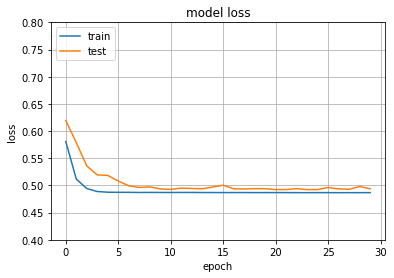

In [31]:
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0.4, 0.8)
plt.grid()

### Inference (Results)
We expect that the autoencoder can NOT reconstruct the NG images.
The difference between the input and the reconstructed image would show whether the input is OK or NG.  

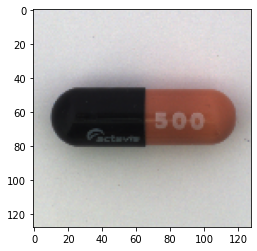

In [32]:
plt.imshow(X_train[0])
plt.show()

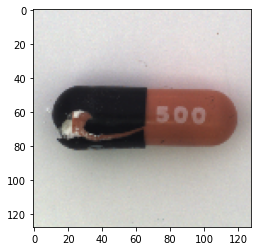

In [33]:
plt.imshow(X_val[1])
plt.show()

In [34]:
def plot_func(img_nad, out, diff_data):
    input_img = img_nad[0, :].squeeze() * 255.
    input_img = input_img.astype(np.uint8)
    output_img = out[0, :].squeeze() * 255.
    output_img = output_img.astype(np.uint8)
    diff_img = diff_data[0, :].squeeze() * 255.
    diff_img = diff_img.astype(np.uint8)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1);plt.axis('off')
    plt.title('original\n')
    plt.imshow(input_img)

    plt.subplot(1, 3, 2);plt.axis('off')
    plt.title('reconstruction\n')
    plt.imshow(output_img)

    plt.subplot(1, 3, 3);plt.axis('off')
    plt.title('diff\n')
    plt.imshow(diff_img, cmap='viridis', vmin=0, vmax=255)

In [35]:
img_array = X_train[0][None, ...]/255.0
predictions = model.predict(img_array)
predictions.shape

(1, 128, 128, 3)

In [36]:
diff_data = np.absolute(img_array - predictions)
diff_data = np.sum(diff_data, axis=-1) / img_ch

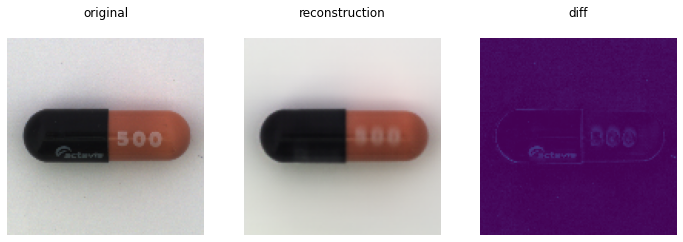

In [37]:
plot_func(img_array, predictions, diff_data)

In [83]:
img_array = X_val[1][None, ...]/255.0
predictions = model.predict(img_array)
predictions.shape

(1, 128, 128, 3)

In [84]:
diff_data = np.absolute(img_array - predictions)
diff_data = np.sum(diff_data, axis=-1) / img_ch

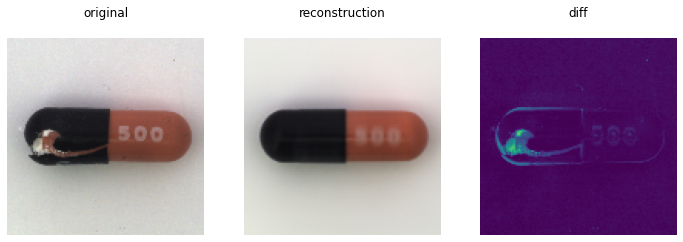

In [85]:
plot_func(img_array, predictions, diff_data)

### Future work
My model is still not precise enough to detect a small defect.
I should try to use the advanced model other than the basic CAE.